<u>**Scratch Work for the Final Project**<u>

In [1]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import streamlit as st
from tabulate import tabulate
import plotly.express as px

In [2]:
### Load Data
file_path = "data/netflix_titles.csv"      # Make sure the file is in your active directory
df = pd.read_csv(file_path)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
def load_data(file_path = "data/netflix_titles.csv"):
    df = pd.read_csv(file_path)
    return df

In [4]:
### Functions to clean the data:
def cleanNetflixData(df,
                     estimateSeasonMinutes=False,
                     episodesPerSeason=10,
                     minutesPerEpisode=45,
                     explodeGenres=False,
                     standardizeGenres=True): # Added option to standardize genres

    df = df.copy()

    # --- 0) Trim whitespace in all object columns & normalize empties ---
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].replace({"": np.nan, "nan": np.nan, "None": np.nan})

    # --- 1) Dates: parse and derive parts ---
    if "date_added" in df.columns:
        df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
        df["year_added"]  = df["date_added"].dt.year.astype("Int64")
        df["month_added"] = df["date_added"].dt.month.astype("Int64")

    # --- 2) Type normalization ---
    if "type" in df.columns:
        df["type"] = df["type"].str.title()  # 'Movie' / 'Tv Show' -> 'Movie' / 'Tv Show'
        df["type"] = df["type"].replace({"Tv Show": "TV Show"})

    # --- 3) Rating normalization (unify common TV-* variants) ---
    if "rating" in df.columns:
        r = df["rating"].str.upper().str.replace(" ", "-", regex=False)
        tv_fixes = {
            "TV-MA": "TV-MA", "TV-14": "TV-14", "TV-PG": "TV-PG", "TV-G": "TV-G",
            "TV-Y7": "TV-Y7", "TV-Y": "TV-Y"
        }
        # normalize common spaced forms like "TV MA", "TV 14", etc.
        r = r.replace({
            "TVMA": "TV-MA", "TV14": "TV-14", "TVPG": "TV-PG", "TVG": "TV-G",
            "TVY7": "TV-Y7", "TVY": "TV-Y"
        })
        df["rating"] = r.replace(tv_fixes)

    # --- 4) Duration: extract minutes and seasons ---
    df["duration_minutes"] = pd.to_numeric(
        df.get("duration", pd.Series(index=df.index, dtype="object"))
          .str.extract(r"(\d+)\s*min", expand=False), errors="coerce"
    ).astype("Int64")

    df["seasons"] = pd.to_numeric(
        df.get("duration", pd.Series(index=df.index, dtype="object"))
          .str.extract(r"(\d+)\s*Season", flags=re.IGNORECASE, expand=False),
        errors="coerce"
    ).astype("Int64")

    # Optionally estimate TV show minutes
    if estimateSeasonMinutes:
        est = df["seasons"].astype("Float64") * episodesPerSeason * minutesPerEpisode
        df["duration_minutes"] = df["duration_minutes"].astype("Float64")
        df["duration_minutes"] = df["duration_minutes"].fillna(est).round().astype("Int64")

    # --- 5) Countries: split & primary country ---
    if "country" in df.columns:
        df["country"] = df["country"].fillna("Unknown")
        df["countries"] = df["country"].str.split(r"\s*,\s*")
        df["primary_country"] = df["countries"].apply(lambda xs: xs[0] if isinstance(xs, list) and len(xs) else "Unknown")

    # --- 6) Director / Cast: fill NaN with 'Unknown' for easier grouping & add flags ---
    for c in ["director", "cast"]:
        if c in df.columns:
            df[f"has_{c}"] = df[c].notna() # Add flag for missing director/cast
            df[c] = df[c].fillna("Unknown")


    # --- 7) Genres: split; optionally explode & standardize ---
    if "listed_in" in df.columns:
        df["genres"] = df["listed_in"].fillna("Unknown").str.split(r"\s*,\s*")
        if standardizeGenres:
             # Simple standardization: remove " TV Shows", " Movies", " Series" etc.
            df["genres"] = df["genres"].apply(lambda genre_list: [
                re.sub(r'\s*(TV Shows?|Movies?|Series?|Dramas?)$', '', genre, flags=re.IGNORECASE).strip()
                for genre in genre_list
            ])
    else:
        df["genres"] = [[] for _ in range(len(df))]


    genres_exploded = None
    if explodeGenres:
        genres_exploded = (
            df[["show_id", "title", "genres"]]
            .explode("genres", ignore_index=False)
            .rename(columns={"genres": "genre"})
            .reset_index(drop=False)
            .rename(columns={"index": "row_idx"})
        )

    # --- 8) Dtypes & duplicates ---
    if "release_year" in df.columns:
        df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")
        # Basic validation for release year (e.g., not in the future, not extremely old)
        current_year = pd.Timestamp('now').year
        df.loc[df['release_year'] > current_year + 1, 'release_year'] = pd.NA # Assuming release year shouldn't be more than 1 year in the future
        df.loc[df['release_year'] < 1900, 'release_year'] = pd.NA # Assuming release year shouldn't be before 1900 (adjust as needed)


    df = df.drop_duplicates(subset=["show_id"]).reset_index(drop=True)

    # --- 9) Helpful flags ---
    df["is_movie"] = (df.get("type", "") == "Movie")
    df["is_tv"]    = (df.get("type", "") == "TV Show")


    # --- 10) Extract release month and day (if release_year is valid) ---
    if "release_year" in df.columns:
        # Create a temporary date column to extract month and day, handling NaT
        temp_date = pd.to_datetime(df['release_year'], format='%Y', errors='coerce')
        df['release_month'] = temp_date.dt.month.astype('Int64')
        df['release_day'] = temp_date.dt.day.astype('Int64')


    return (df, genres_exploded) if explodeGenres else (df, None)


## **NEED TO RUN THE DATA CLEANING CODE, THEN LOAD THE CLEAN DATA FOR THE PLOTS **

In [5]:
# Need the _ since the data cleaning function returns 2 objects (including the None)
df_clean, _ = cleanNetflixData(df)

df_clean.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,seasons,countries,primary_country,has_director,has_cast,genres,is_movie,is_tv,release_month,release_day
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,...,<NA>,[United States],United States,True,False,[Documentaries],True,False,1,1
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,...,2,[South Africa],South Africa,False,True,"[International, TV, TV Mysteries]",False,True,1,1
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,...,1,[Unknown],Unknown,True,True,"[Crime, International, TV Action & Adventure]",False,True,1,1
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,...,1,[Unknown],Unknown,False,False,"[Docu, Reality TV]",False,True,1,1
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,...,2,[India],India,False,True,"[International, Romantic, TV Comedies]",False,True,1,1


In [7]:
df_clean.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_added', 'month_added', 'duration_minutes', 'seasons', 'countries',
       'primary_country', 'has_director', 'has_cast', 'genres', 'is_movie',
       'is_tv', 'release_month', 'release_day'],
      dtype='object')

***Don't Need this one***

In [ ]:
### NOT USED
def plot_rating_counts_by_year(df, year=2016, label="Movies and TV Shows"):
    df_ratings = df.dropna(subset=['release_year', 'rating'])
    df_ratings = df_ratings[df_ratings['release_year'] >= year]

    rating_counts = df_ratings.groupby(['release_year', 'rating']).size().unstack(fill_value=0)
    rating_order = rating_counts.sum().sort_values(ascending=False).index
    rating_counts = rating_counts[rating_order]

    fig, ax = plt.subplots(figsize=(10, 8))
    bottom = pd.Series([0]*rating_counts.shape[0], index=rating_counts.index)
    colors = plt.cm.tab20.colors

    for i, rating in enumerate(rating_counts.columns):
        ax.barh(
            rating_counts.index,
            rating_counts[rating],
            left=bottom,
            label=rating,
            color=colors[i % len(colors)]
        )
        for y, x in enumerate(bottom + rating_counts[rating]/2):
            count = rating_counts[rating].iloc[y]
            if count > 20:
                ax.text(x, rating_counts.index[y], str(count),
                        ha='center', va='center', fontsize=9, color='white')
        bottom += rating_counts[rating]

    ax.set_xlabel(f'Number of {label}')
    ax.set_ylabel('Release Year')
    ax.set_title(f'Stacked Count of {label} Ratings from {year} onwards (Counts > 20)')
    ax.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    st.pyplot(fig)

## ***RUN THIS***

In [6]:
# Movies only
df_movies = df_clean[df_clean['type'] == 'Movie'].copy()

# TV Shows only
df_tv = df_clean[df_clean['type'] == 'TV Show'].copy()

In [ ]:
plot_rating_counts_by_year(df_movies, 2018)

## ***RUN THIS***

In [11]:
### USE THIS
def show_rating_table(df, year = 2016, label = "Movies and TV Shows"):
    df_ratings = df.dropna(subset=['release_year', 'rating'])
    df_ratings = df_ratings[df_ratings['release_year'] >= year]

    rating_counts = df_ratings.groupby(['release_year', 'rating']).size().unstack(fill_value=0)
    styled_table = rating_counts.style.background_gradient(cmap='YlGnBu', axis=None)\
                                       .set_caption(f"{label} Ratings Count per Year")                         
    st.dataframe(styled_table)

In [10]:
show_rating_table(df_movies, label = "Movies")

2025-11-30 21:17:15.153 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 21:17:15.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 21:17:15.189 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 21:17:15.189 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


***USE THIS***

In [41]:
def plot_top_genres_by_country(df, country='United States', top_n=5):
    df_country = df[df['country'] == country].dropna(subset=['listed_in', 'release_year'])
    df_genres = df_country.assign(genre=df_country['listed_in'].str.split(', ')).explode('genre')

    genre_counts = df_genres.groupby(['release_year', 'genre']).size().reset_index(name='count')
    top_genres = genre_counts.groupby('genre')['count'].sum().sort_values(ascending=False).head(top_n).index
    genre_counts_top = genre_counts[genre_counts['genre'].isin(top_genres)]

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.lineplot(data=genre_counts_top, x='release_year', y='count', hue='genre', marker='o', ax=ax)
    ax.set_title(f'Top {top_n} Genres in {country} Over Time')
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Number of Projects')
    ax.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    #st.pyplot(fig)

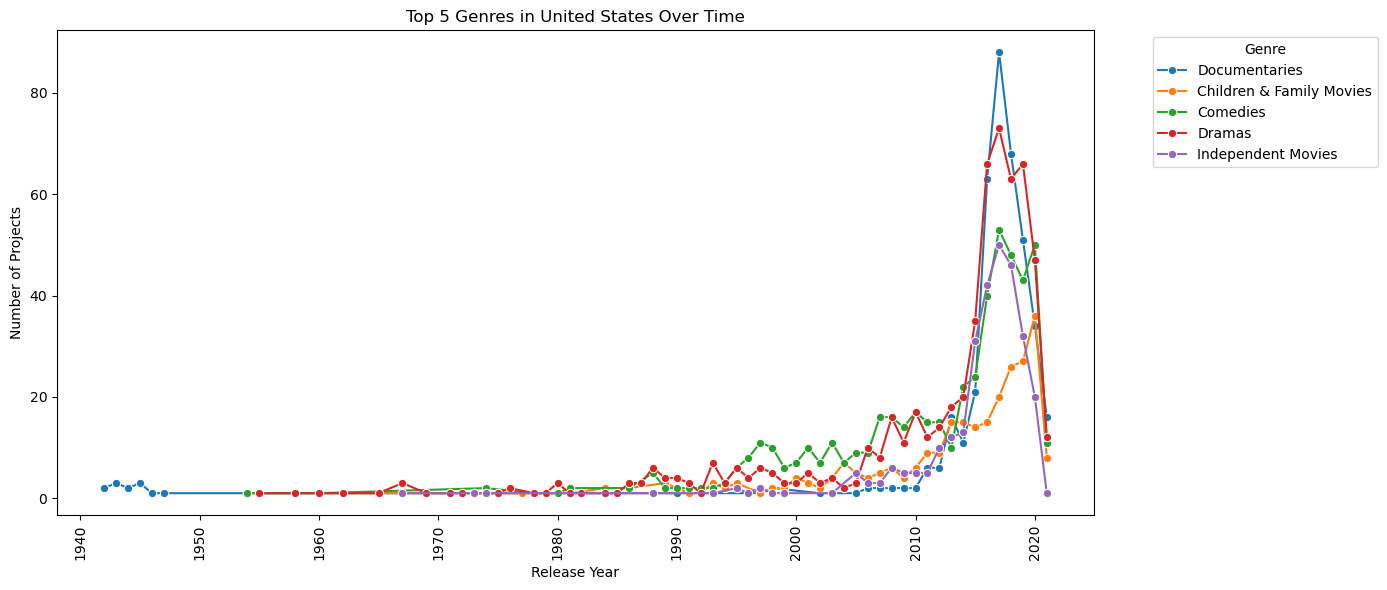

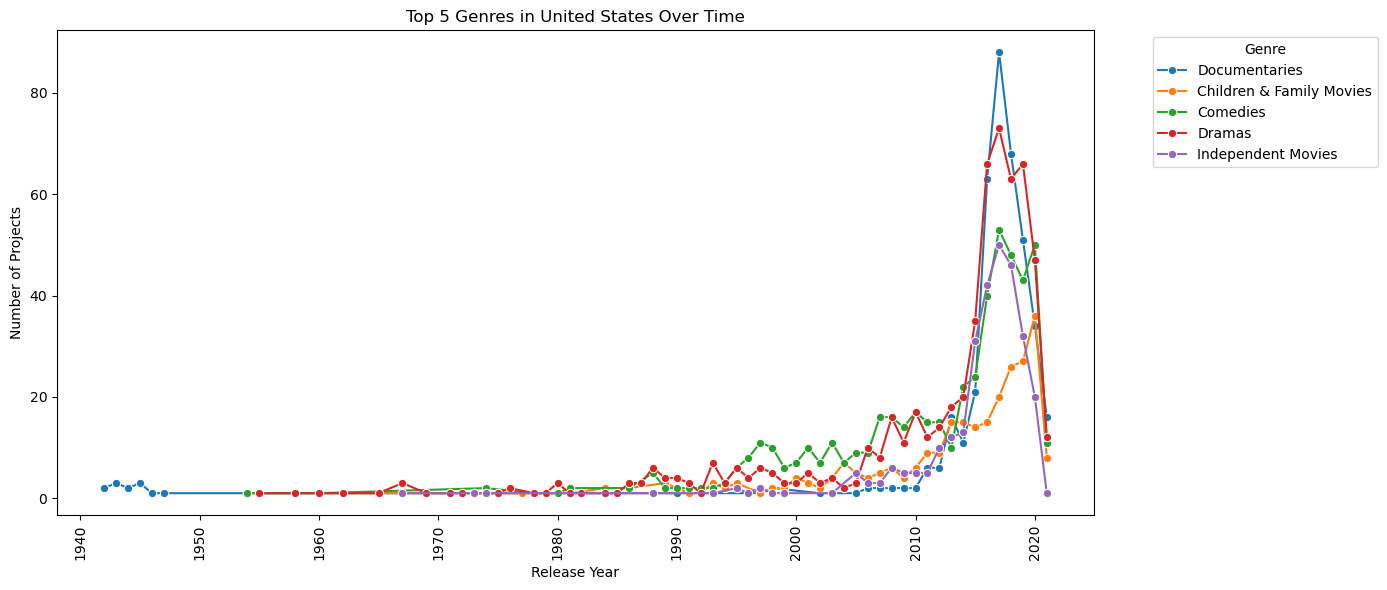

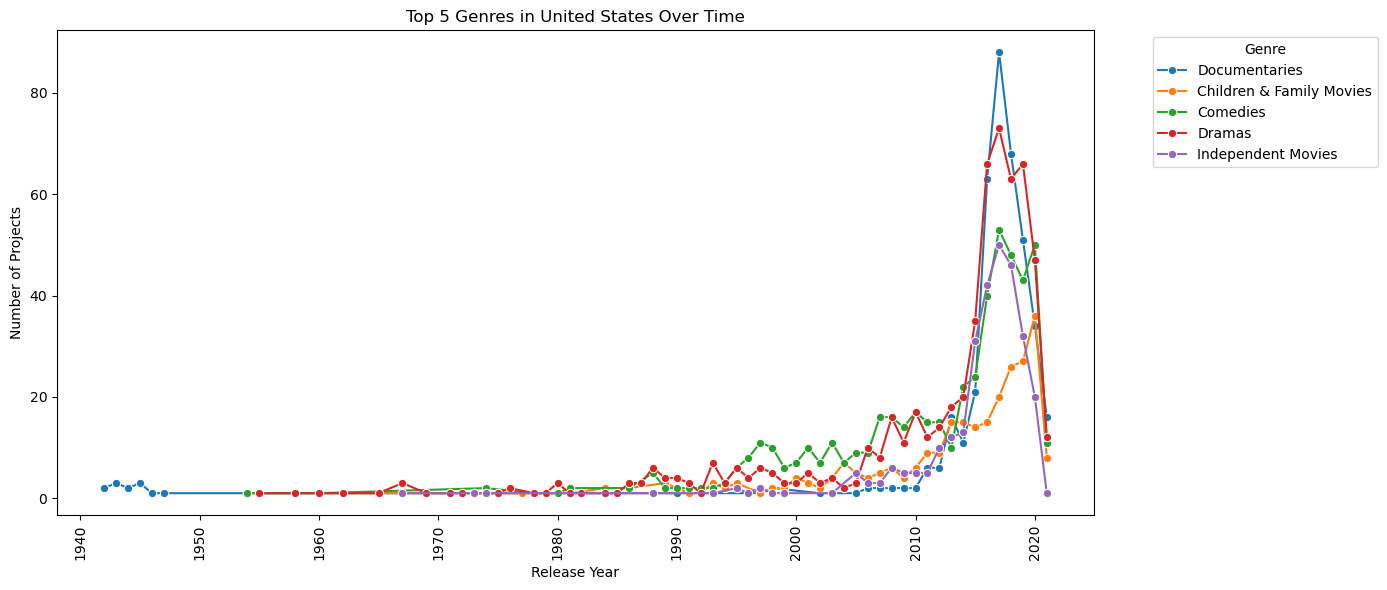

In [42]:
plot_top_genres_by_country(df_clean)

***Movie Recommender System based on Genre + Keywords***

In [ ]:
### Keyword matching function
def keyword_match(df, keywords, match_mode='any'):
    """
    Filters movies whose description contains any or all of the keywords.
    """
    if match_mode == 'all':
        return df[df['description'].apply(
            lambda desc: all(re.search(re.escape(k), str(desc), re.IGNORECASE) for k in keywords)
        )]
    else:
        pattern = '|'.join([re.escape(k) for k in keywords])
        return df[df['description'].str.contains(pattern, case=False, na=False)]

### Filtering to only include movies that match the genres provided
def genre_filter(df, genre_list, match_mode='any'):
    """
    Filters movies that match any or all of the genres provided.
    """
    genre_list_lower = [g.lower() for g in genre_list]

    def match_genres(g):
        g_lower = [x.lower() for x in g if x]
        if match_mode == 'all':
            return all(genre in g_lower for genre in genre_list_lower)
        else:
            return any(genre in g_lower for genre in genre_list_lower)

    return df[df['genres_list'].apply(match_genres)]

### Recommending top movies based on inputs
def recommend_movies(df, keywords=None, genres=None, top_n=10, keyword_match_mode='any', genre_match_mode='any'):
    """
    Recommends top-rated movies based on keyword and genre filters.
    Match modes: 'any' or 'all' for both keywords and genres.
    """
    filtered = df.copy()

    if keywords:
        filtered = keyword_match(filtered, keywords, match_mode=keyword_match_mode)
        print(f"🔍 Keyword filter: {len(filtered)} matches for {keywords} ({keyword_match_mode})")

    if genres:
        filtered = genre_filter(filtered, genres, match_mode=genre_match_mode)
        print(f"🎬 Genre filter: {len(filtered)} matches for {genres} ({genre_match_mode})")

    print(f"✅ Final filtered set: {len(filtered)} movies")

    if filtered.empty:
        print("⚠️ No matches found. Try relaxing your keywords or genre filters.")
        return pd.DataFrame(columns=['title', 'rating', 'genres', 'description'])

    return (
        filtered
        .sort_values(by='title', ascending=False)
        .loc[:, ['title', 'rating', 'genres', 'description']]
        .head(top_n)
    )


### Run the recommender
def run_recommender(df, keywords, genres, top_n=10, keyword_match_mode='any', genre_match_mode='any'):
    """
    Wrapper for Streamlit app to run the recommender system.
    """
    return recommend_movies(
        df,
        keywords=keywords,
        genres=genres,
        top_n=top_n,
        keyword_match_mode=keyword_match_mode,
        genre_match_mode=genre_match_mode
    )

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...


True

In [9]:
import re
from rapidfuzz import fuzz, process
from nltk.corpus import wordnet

def expand_synonyms(keywords):
    """Expand keywords with WordNet synonyms."""
    expanded = set()
    for k in keywords:
        expanded.add(k.lower())
        for syn in wordnet.synsets(k):
            for lemma in syn.lemmas():
                expanded.add(lemma.name().lower().replace('_', ' '))
    return list(expanded)

from rapidfuzz import fuzz

def keyword_match_fuzzy(df, keywords, match_mode='any', threshold=70):
    """
    Filters movies whose description contains fuzzy matches of the keywords.
    - threshold: similarity score (0–100) for fuzzy matching
    """
    def match_desc(desc):
        tokens = str(desc).lower().split()
        if match_mode == 'all':
            return all(
                any(fuzz.partial_ratio(k.lower(), token) >= threshold for token in tokens)
                for k in keywords
            )
        else:
            return any(
                any(fuzz.partial_ratio(k.lower(), token) >= threshold for token in tokens)
                for k in keywords
            )
    return df[df['description'].apply(match_desc)]

In [13]:
# Example: test fuzzy matching on your actual dataset
results = keyword_match_fuzzy(df_clean, ["colour"], match_mode="any", threshold=70)

print(f"Found {len(results)} matches")
results[['description']].head(10)  # preview first 10 matches

Found 825 matches


,description
14,Cameras following Bengaluru police on the job ...
15,Students of color navigate the daily slights a...
36,"Tired of the small-time grind, three Marseille..."
42,Four years after the last deadly shark attacks...
43,After the staff of a marine theme park try to ...
48,A rookie cop with one day to prove himself to ...
58,When four out of five ninja villages are destr...
73,When a powerful businesswoman’s political ambi...
77,Kid cop Little Singham loses all his superpowe...
80,"When his home is threatened by humans, a young..."


***Plotting***

***Categorizing Movies based on Description***

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

# Assume df_movies is already loaded and cleaned
descriptions = df_movies["description"].fillna("").astype(str)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.8,
    min_df=5,
    max_features=1000
)
tfidf = vectorizer.fit_transform(descriptions)

In [60]:
# Choose number of topics (e.g., 8)
n_topics = 8
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(tfidf)  # movie-topic matrix
H = nmf.components_           # topic-word matrix

feature_names = vectorizer.get_feature_names_out()
topic_labels = []

for topic_idx, topic in enumerate(H):
    top_keywords = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    label = ", ".join(top_keywords)
    topic_labels.append(f"Topic {topic_idx+1}: {label}")

In [63]:
for label in topic_labels:
    print(label)

Topic 1: young, man, woman, father, finds
Topic 2: new, york, city, finds, home
Topic 3: documentary, follows, explores, story, interviews
Topic 4: stand, special, comedian, comedy, comic
Topic 5: life, love, death, comes, career
Topic 6: school, high, friends, old, year
Topic 7: family, home, father, son, returns
Topic 8: world, war, ii, save, tour


In [61]:
dominant_topic = W.argmax(axis=1)
df_movies["topic_num"] = dominant_topic + 1  # 1-indexed
df_movies["topic_label"] = [topic_labels[i] for i in dominant_topic]

In [ ]:
df_movies[["title", "description", "topic_label"]].head(10)

In [ ]:
import matplotlib.pyplot as plt

def plot_top_words(H, feature_names, topic_idx, top_n=10):
    topic = H[topic_idx]
    top_indices = topic.argsort()[:-top_n-1:-1]
    top_words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top_words[::-1], weights[::-1])
    plt.title(f"Top Words for Topic {topic_idx+1}")
    plt.xlabel("Weight")
    plt.tight_layout()
    plt.show()
    


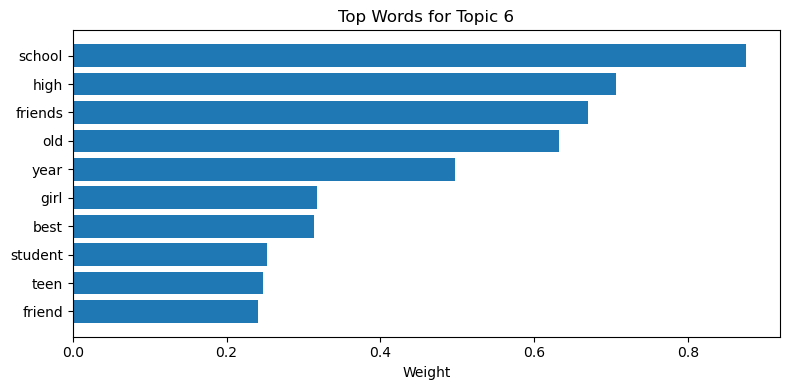

In [70]:
### Plot top words per topic (change topic_idx up to 7)
plot_top_words(H, feature_names, topic_idx=5)

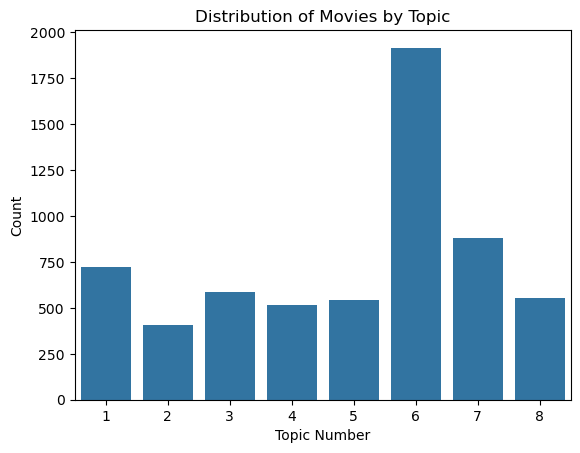

In [69]:
### Topic distribution among movies
import seaborn as sns

sns.countplot(x=df_movies["topic_num"])
plt.title("Distribution of Movies by Topic")
plt.xlabel("Topic Number")
plt.ylabel("Count")
plt.show()

***Clustering Topics***

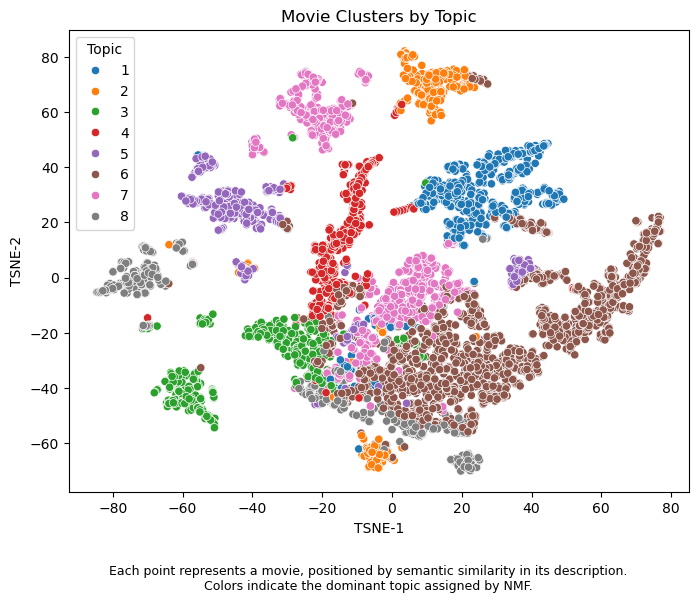

In [72]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(W)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df_movies["topic_num"], palette="tab10")
plt.title("Movie Clusters by Topic")
plt.figtext(0.5, -0.05,
            "Each point represents a movie, positioned by semantic similarity in its description.\nColors indicate the dominant topic assigned by NMF.",
            wrap=True, horizontalalignment='center', fontsize=9)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Topic")
plt.show()

***Movies vs TV Show Volume Over Time***

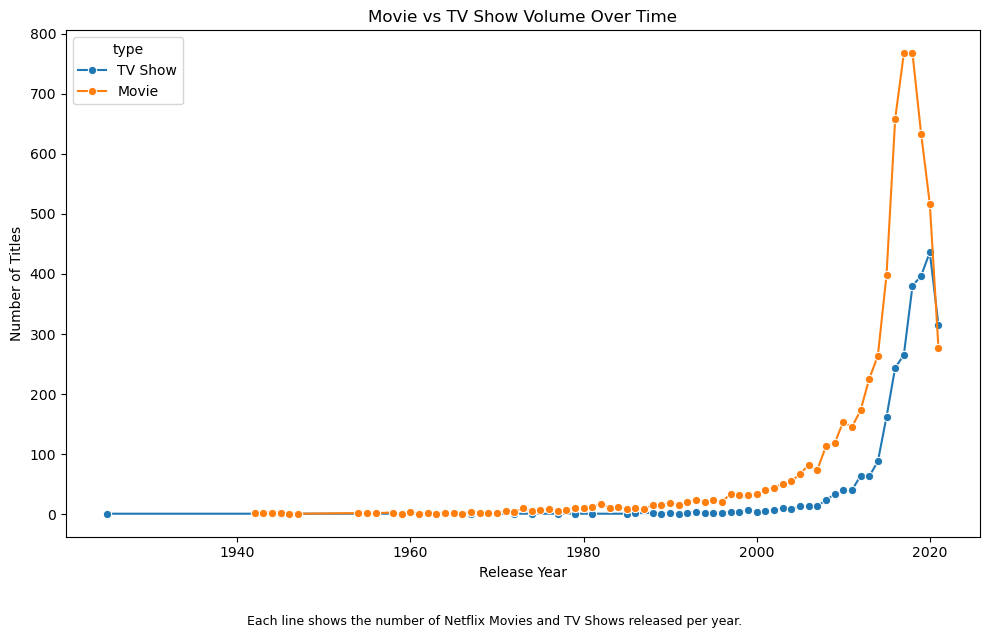

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter valid years
df_years = df_clean[df_clean["release_year"].notna() & df_clean["type"].notna()]

# Group and count
counts = df_years.groupby(["release_year", "type"]).size().reset_index(name="count")

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=counts, x="release_year", y="count", hue="type", marker="o")
plt.title("Movie vs TV Show Volume Over Time")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.figtext(0.5, -0.05,
            "Each line shows the number of Netflix Movies and TV Shows released per year.",
            wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()

In [12]:
### Above as a function
def plot_movie_tv_trends(df):
    # Filter valid years
    df_years = df[df["release_year"].notna() & df["type"].notna()]

    # Group and count
    counts = df_years.groupby(["release_year", "type"]).size().reset_index(name="count")

    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=counts, x="release_year", y="count", hue="type", marker="o")
    plt.title("Movie vs TV Show Volume Over Time")
    plt.xlabel("Release Year")
    plt.ylabel("Number of Titles")
    plt.figtext(0.5, -0.05,
                "Each line shows the number of Netflix Movies and TV Shows released per year.",
                wrap=True, horizontalalignment='center', fontsize=9)
    plt.tight_layout()
    plt.show()

***Map of Content Volume by Country***

In [90]:
import plotly.express as px

# Count titles per country
country_counts = df_clean["primary_country"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

# Plot
fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    color_continuous_scale="Reds",
                    title="Netflix Content Volume by Country")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [ ]:
### Above as a function:
def plot_country_distribution(df):
    # Count titles per country
    country_counts = df["primary_country"].value_counts().reset_index()
    country_counts.columns = ["country", "count"]

    # Plot
    fig = px.choropleth(country_counts,
                        locations="country",
                        locationmode="country names",
                        color="count",
                        color_continuous_scale="Reds",
                        title="Netflix Content Volume by Country")
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig.show()

***Most Frequent Actors***

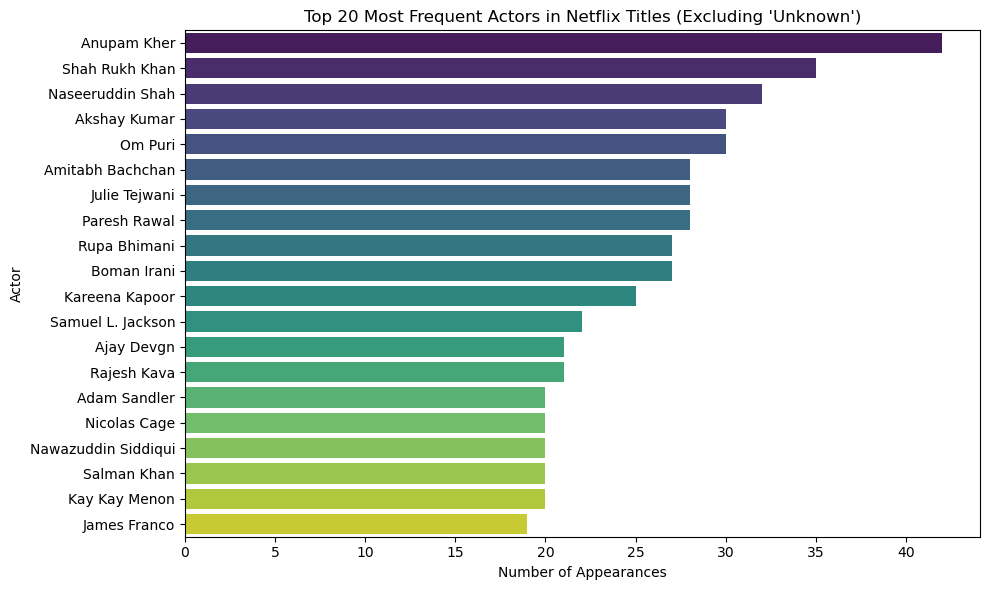

In [ ]:
from collections import Counter

# Flatten and count actors, excluding "Unknown"
all_actors = df_movies["cast"].dropna().str.split(", ").explode()
filtered_actors = all_actors[all_actors.str.lower() != "unknown"]
actor_counts = Counter(filtered_actors)

# Top 20
top_actors = pd.DataFrame(actor_counts.most_common(20), columns=["actor", "count"])

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_actors, y="actor", x="count", palette="viridis")
plt.title("Top 20 Most Frequent Actors in Netflix Titles (Excluding 'Unknown')")
plt.xlabel("Number of Appearances")
plt.ylabel("Actor")
plt.tight_layout()
plt.show()

In [ ]:
### Above as a function:
def plot_top_actors(df, top_n=20):
    # Flatten and count actors, excluding "Unknown"
    all_actors = df["cast"].dropna().str.split(", ").explode()
    filtered_actors = all_actors[all_actors.str.lower() != "unknown"]
    actor_counts = Counter(filtered_actors)

    # Top 20
    top_actors = pd.DataFrame(actor_counts.most_common(20), columns=["actor", "count"])

    # Plot
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_actors, y="actor", x="count", palette="viridis")
    plt.title("Top 20 Most Frequent Actors in Netflix Titles (Excluding 'Unknown')")
    plt.xlabel("Number of Appearances")
    plt.ylabel("Actor")
    plt.tight_layout()
    plt.show()

***Vader Sentiment Comparison***

In [84]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply to your NLP text column (e.g., description or nlp_text)
df_movies["vader_compound"] = df_movies["description"].fillna("").astype(str).map(
    lambda text: analyzer.polarity_scores(text)["compound"]
)

In [88]:
maturity_order = [
    "TV-Y", "TV-Y7", "TV-Y7-FV", "TV-G", "G", "PG", "TV-PG",
    "PG-13", "TV-14", "R", "TV-MA", "NC-17", "UR", "NR",
    "66-MIN", "74-MIN", "84-MIN"
]

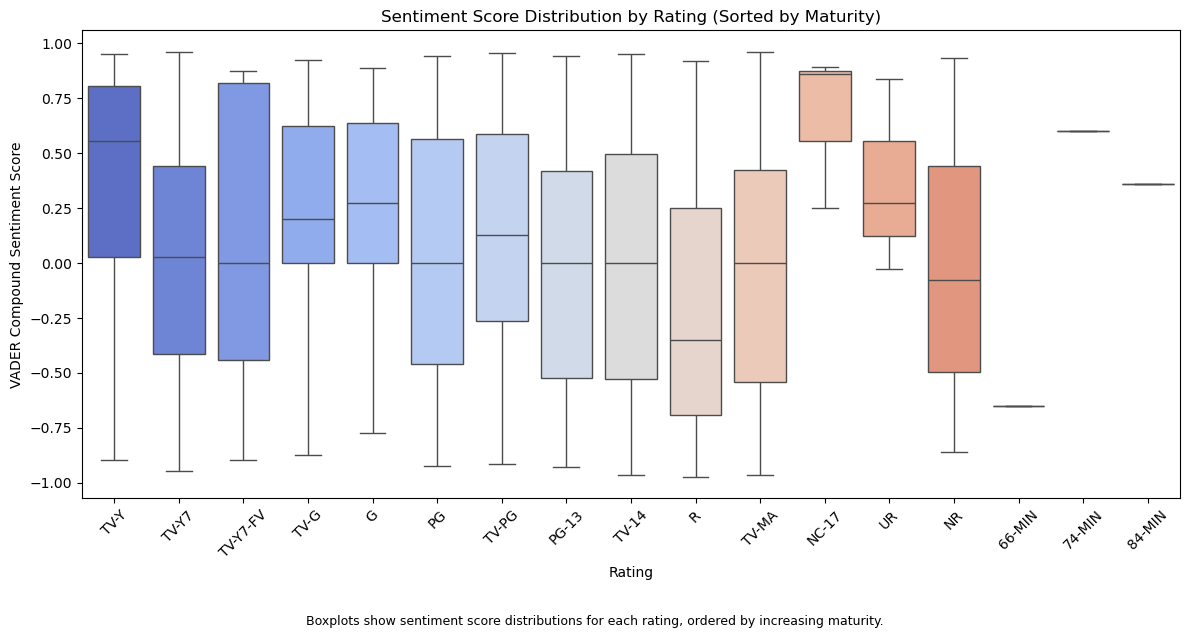

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

df_sent = df_movies[df_movies["vader_compound"].notna() & df_movies["rating"].notna()]
df_sent = df_sent[df_sent["rating"].isin(maturity_order)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sent, x="rating", y="vader_compound", order=maturity_order, palette="coolwarm")
plt.title("Sentiment Score Distribution by Rating (Sorted by Maturity)")
plt.xlabel("Rating")
plt.ylabel("VADER Compound Sentiment Score")
plt.xticks(rotation=45)
plt.figtext(0.5, -0.05,
            "Boxplots show sentiment score distributions for each rating, ordered by increasing maturity.",
            wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
### Above as a function:
def plot_sentiment_by_rating(df):
    maturity_order = [
        "TV-Y", "TV-Y7", "TV-Y7-FV", "TV-G", "G", "PG", "TV-PG",
        "PG-13", "TV-14", "R", "TV-MA", "NC-17", "UR", "NR",
        "66-MIN", "74-MIN", "84-MIN"
    ]
    
    # Analyze
    analyzer = SentimentIntensityAnalyzer()

    # Apply to your NLP text column (e.g., description or nlp_text)
    df["vader_compound"] = df["description"].fillna("").astype(str).map(
        lambda text: analyzer.polarity_scores(text)["compound"]
    )
    
    df_sent = df[df["vader_compound"].notna() & df["rating"].notna()]
    df_sent = df_sent[df_sent["rating"].isin(maturity_order)]

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_sent, x="rating", y="vader_compound", order=maturity_order, palette="coolwarm")
    plt.title("Sentiment Score Distribution by Rating (Sorted by Maturity)")
    plt.xlabel("Rating")
    plt.ylabel("VADER Compound Sentiment Score")
    plt.xticks(rotation=45)
    plt.figtext(0.5, -0.05,
                "Boxplots show sentiment score distributions for each rating, ordered by increasing maturity.",
                wrap=True, horizontalalignment='center', fontsize=9)
    plt.tight_layout()
    plt.show()
    
